In [1]:
from run_gom_mp import *
import pandas as pd
import xarray as xr
from datetime import timedelta as delta

from parcels import plotTrajectoriesFile

In [1]:
# RUN SIMULATION
%run -i gom_mp_kernels.py
%run -i run_gom_mp_backwards.py

fieldset, pset = run_gom_mp_backwards('testing_output/b_test.zarr')

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
INFO: Compiled ArrayNurdleAdvectionRK4BeachTestingUnBeachingStokesUVBeachTestingSmagDiff2BeachTestingAgeing2 ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib1683794923dabb993a046fc6c279d64a_0.dll
INFO: Output files are stored in testing_output/b_test.zarr.
100%|██████████| 5184000.0/5184000.0 [06:11<00:00, 13970.80it/s]         


In [3]:
test = xr.open_zarr('testing_output/b_test.zarr')
gom_masks = xr.open_dataset('data/gom_masks_w_inputs.nc')

In [5]:
test_dd  = test.to_dask_dataframe().compute()

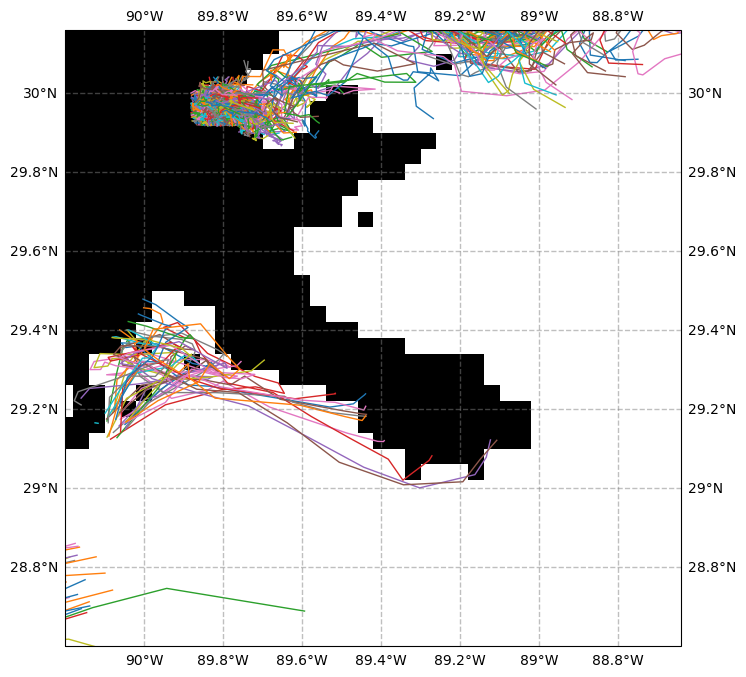

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean 

res_scale= 1/25
lon_bins = np.arange(MIN_LON, MAX_LON, res_scale)
lat_bins = np.arange(MIN_LAT, MAX_LAT, res_scale)

X_land,Y_land = np.meshgrid(gom_masks.landmask['Latitude'],gom_masks.landmask['Longitude'],  indexing='ij')

fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax.coastlines(resolution='50m')
ax.pcolormesh(Y_land, X_land, gom_masks.landmask,cmap='Greys')

ax.set_extent([ -90.2, -88.64, 28.6, 30.16], ccrs.PlateCarree())


_ = ax.plot(test['lon'].T, test['lat'].T, linewidth=1, zorder=1)
# H, xedges, yedges = np.histogram2d(test_dd_clean['lon'], test_dd_clean['lat'], bins=(lon_bins, lat_bins))
# ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap=cmocean.cm.matter , vmin=0.0, rasterized=True)
